In [1]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt

In [105]:
#xmax =  data['XCOORD'].max()
#xmin =  data['XCOORD'].min()
#xrange = xmax-xmin
#ymax =  data['YCOORD'].max()
#ymin =  data['YCOORD'].min()
#yrange = ymax-ymin

#xgridsize = 50
#ygridsize = int(xgridsize*yrange/xrange)

#points = []
#for i in range(0, 400):
#    point = assign_to_grid(data['XCOORD'][i], data['YCOORD'][i], xgridsize, ygridsize, xmin, xrange, ymin, yrange)
#    points.append(point)
#plt.plot(*zip(*points), marker='o', color='b', ls='')
#plt.title("Gridded Event Locations")
def assign_to_grid(xcord, ycord, xgridsize, ygridsize, xmin, xrange, ymin, yrange):
    # Assign a lat and long coordinate to a grid location. Input xcord, ycord as lat/long to be mapped
    # gridsize is dimension of matrix
    # min is smallest lat/long coordinate, range is max(xcoordinate) - min(xcoordinate) and repeat for y
    
    xbin = int((xcord-xmin)/(xmax-xmin)*(xgridsize-1))
    ybin = int((ycord-ymin)/(ymax-ymin)*(ygridsize-1))
    return xbin, ybin

In [106]:
def grid_to_coord(xbin, ybin, xgridsize, ygridsize, xmin, xrange, ymin, yrange):
    xcord = (xbin * (xmax - xmin)) / (xgridsize -1) + xmin
    ycord = (ybin * (ymax - ymin)) / (ygridsize -1) + ymin
    return xcord, ycord

In [107]:
def global_update(F_xy, w, time_delta_last_time, theta, mu_xy):
# Decay triggering exponentials and calculate current intensities for all grids
    for k in range(0, len(w)):
        F_xy[k] = F_xy[k] * np.exp(-1*w[k]*time_delta_last_time)
        # To possibly avoid underflow problem
        if F_xy[k] < 1e-70:
            F_xy[k] = 1e-70
    Lam_xy = mu_xy+sum(F_xy)
    
    return F_xy, Lam_xy

In [108]:
def event_update(mu_g, Lam_g, time_delta_last_g_time, theta, w, F_g, time_delta_last_time):
# update mu, theta and triggering exponentials for grids where event occurred
    dt = .005 
    mu_g = mu_g + dt*(mu_g/Lam_g - mu_g*time_delta_last_g_time)
    for k in range(0, len(w)):
        theta[k] = theta[k] + dt * (F_g[k]/Lam_g-theta[k])
        F_g[k] = F_g[k] + w[k]*theta[k]
    return mu_g, theta, F_g

#### Actual data

In [98]:
full_data = pd.read_csv('FixedLatLongTimeLoc_AndTimeSorted.csv')
full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data.head()

C:\Users\rjhosler\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,CALL_NO,UNIT_DISPATCH_DATE,DISPATCH_TIME,CALL_TYPE_FINAL,CALL_TYPE_FINAL_D,XCOORD,YCOORD,DATE_TIME
0,0,0,61209515,2006-12-28,44548,773A,UNCONSCIOUS PERS,39.824332,-86.236119,2006-12-28 04:45:48
1,1,1,61209516,2006-12-28,44853,774A,ASSAULT/TRAUMA,39.781627,-86.120826,2006-12-28 04:48:53
2,2,2,61209517,2006-12-28,45219,768A,SEIZURE,39.756840,-85.998714,2006-12-28 04:52:19
3,3,3,61209519,2006-12-28,51057,773A,UNCONSCIOUS PERS,39.782064,-86.044592,2006-12-28 05:10:57
4,4,4,61209520,2006-12-28,51756,790A,*MEDICAL ALARM,39.742415,-86.111559,2006-12-28 05:17:56


In [6]:
Event_Type_Lookup = {}
for i in range(0, len(full_data)):
    key = full_data.CALL_TYPE_FINAL[i]
    val = full_data.CALL_TYPE_FINAL_D[i]
    Event_Type_Lookup.setdefault(key, [])
    Event_Type_Lookup[key].append(val)

In [109]:
# select subset of data to work with
data = full_data[600670:601070]
data.reset_index(drop=True, inplace=True)

In [110]:
np.seterr(all='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'warn'}

In [101]:
data['gx'] = 0
data['gy'] = 0

C:\Users\rjhosler\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rjhosler\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [111]:
# set up grid sizing
xmax =  data['XCOORD'].max()
xmin =  data['XCOORD'].min()
xrange = xmax-xmin
ymax =  data['YCOORD'].max()
ymin =  data['YCOORD'].min()
yrange = ymax-ymin

ygridsize = 100
xgridsize = 100

# initial parameters
w = [.5, .1, .05]
theta = [.5, .4, .3]

mu = np.ones([xgridsize, ygridsize])*.1
F = np.ones([xgridsize, ygridsize, len(w)])
Lam = np.ones([len(data), xgridsize, ygridsize])*0.0001

# for storing time of past event in specific grid cell
G_times = pd.DataFrame(np.zeros([xgridsize, ygridsize]))
G_times[:] = data.DATE_TIME[0]

# (tracking model parameters)
theta_track = np.zeros([len(data), len(theta)])

table = np.zeros ((len(data), 2))
revtable = np.zeros ((len(data), 2))

for i in range(1, len(data)):
    # assign event to a grid
    gx, gy = assign_to_grid(data.XCOORD[i], data.YCOORD[i], xgridsize, ygridsize, xmin, xrange, ymin, yrange)
    table[i, 0] = gx
    table[i, 1] = gy
    xcord, ycord = grid_to_coord(gx, gy, xgridsize, ygridsize, xmin, xrange, ymin, yrange)
    revtable[i, 0] = xcord
    revtable[i, 1] = ycord
    # time since last event in any grid box 
    time_delta = (data.DATE_TIME[i]- data.DATE_TIME[i-1]).total_seconds()
    
    # update exponentials, intensities for all grid boxes
    for x in range(xgridsize):
        for y in range(ygridsize):
            F[x][y], Lam[i][x][y] = global_update(F[x][y], w, time_delta, theta, mu[x][y]) 
            
    # find last time event occurred at this grid location
    last_g_time = pd.to_datetime(G_times.at[gx,gy])
    # find delta between last event time and current time. 
    g_time_delta = (data.DATE_TIME[i] - last_g_time).total_seconds()
    # update event time for this location
    G_times.at[gx,gy] = data.DATE_TIME[i]
    
    # update model parameters based on grid box where current event happened
    mu[gx][gy], theta, F[gx][gy] = event_update(mu[gx][gy], Lam[i][gx][gy], g_time_delta, theta, w, F[gx][gy], time_delta)
    
    # (tracking model parameters)
    theta_track[i] = theta
    
    #print(i/events*100) F_xy is really small


C:\Users\rjhosler\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: underflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\rjhosler\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: underflow encountered in double_scalars
  after removing the cwd from sys.path.


In [112]:
data['gx'] = table [:,0]
data['gy'] = table [:,1]
data['revx'] = revtable [:,0]
data['revy'] = revtable [:,1]

C:\Users\rjhosler\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\rjhosler\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rjhosler\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [113]:
data

,Unnamed: 0,Unnamed: 0.1,CALL_NO,UNIT_DISPATCH_DATE,DISPATCH_TIME,CALL_TYPE_FINAL,CALL_TYPE_FINAL_D,XCOORD,YCOORD,DATE_TIME,gx,gy,revx,revy
0,600670,600670,131003847,2013-10-09,132003,766A,DIFF BREATHING,39.851744,-86.097600,2013-10-09 13:20:03,0.0,0.0,0.000000,0.000000
1,600671,600671,131003848,2013-10-09,132159,766A,DIFF BREATHING,39.756114,-86.126656,2013-10-09 13:21:59,40.0,44.0,39.754424,-86.129673
2,600672,600672,131003850,2013-10-09,133532,766A,DIFF BREATHING,39.823969,-86.240099,2013-10-09 13:35:32,63.0,9.0,39.821768,-86.241503
3,600673,600673,131003852,2013-10-09,133757,792B,INJURED PERSON,39.921659,-86.138034,2013-10-09 13:37:57,97.0,41.0,39.921320,-86.139259
4,600674,600674,131003855,2013-10-09,134221,792B,INJURED PERSON,39.906931,-86.044355,2013-10-09 13:42:21,92.0,70.0,39.906680,-86.046600
5,600675,600675,131003857,2013-10-09,134953,765A,CHEST PAIN/HRT,39.879894,-86.067731,2013-10-09 13:49:53,82.0,63.0,39.877400,-86.068966
6,600676,600676,131003858,2013-10-09,135507,766A,DIFF BREATHING,39.804319,-86.157844,2013-10-09 13:55:07,57.0,35.0,39.804200,-86.158430
7,600677,600677,131003859,2013-10-09,135751,766A,DIFF BREATHING,39.839523,-86.171602,2013-10-09 13:57:51,69.0,30.0,39.839336,-86.174405
8,600678,600678,131003860,2013-10-09,140301,776A,BLEEDING/NONTRAU,39.732166,-86.132296,2013-10-09 14:03:01,32.0,43.0,39.731000,-86.132869
9,600679,600679,131003861,2013-10-09,140629,790A,SICK PERSON,39.770057,-86.080042,2013-10-09 14:06:29,45.0,59.0,39.769064,-86.081746


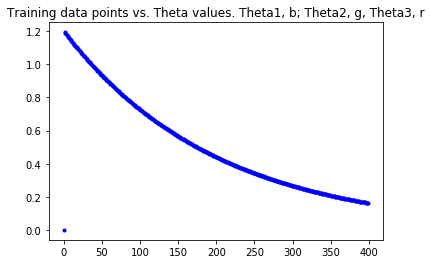

In [59]:
t_est = []
for i in range(0, len(data)):
    t_est.append(sum(theta_track[i]))
plt.plot(t_est, 'b.')
plt.title('Training data points vs. Theta values. Theta1, b; Theta2, g, Theta3, r')
plt.show()


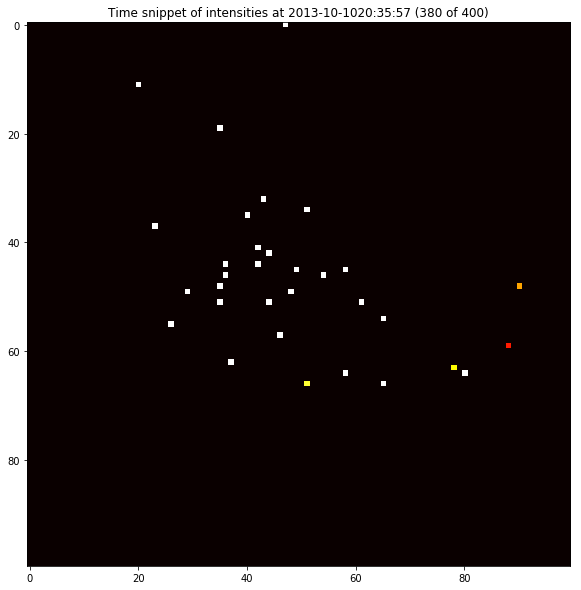

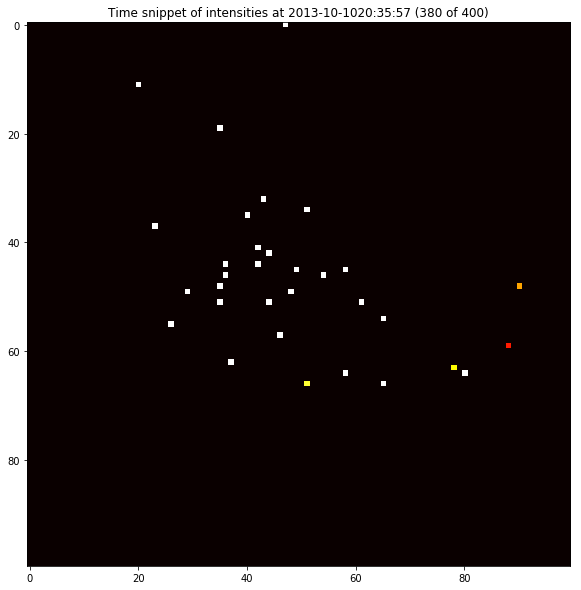

In [60]:
import time
import pylab as pl
from IPython import display
plt.figure(figsize=(20,10))
end = len(data)
for n in range(0, int(end/20)): 
    i = n*20
    plt.title('Time snippet of intensities at '+data.DATE_TIME[i].strftime('%Y-%m-%d%H:%M:%S') + ' ('+str(i)+' of ' + str(end) +')')
    plt.imshow((Lam[i]), cmap = 'hot', interpolation = 'nearest', vmin = 0, vmax = 225)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.0005)
# color scale from black (low) to white (high)

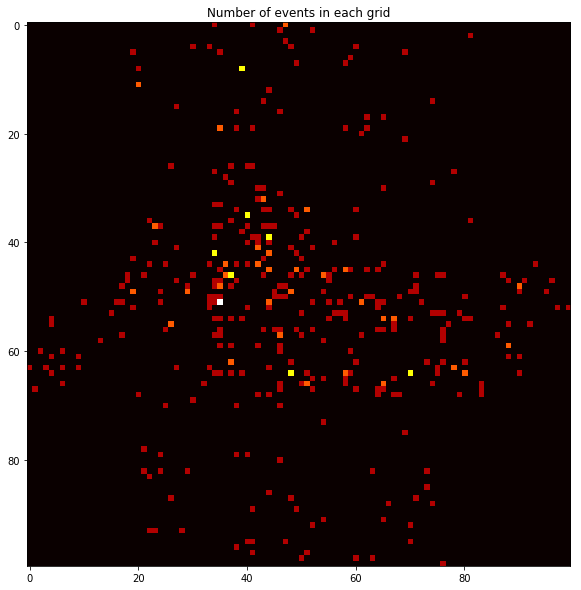

In [61]:
data_intensity = np.zeros([xgridsize, ygridsize])
for i in range(0, len(data)):
    x, y = assign_to_grid(data['XCOORD'][i], data['YCOORD'][i], xgridsize, ygridsize, xmin, xrange, ymin, yrange)
    data_intensity[x][y] = data_intensity[x][y] + 1

plt.figure(figsize=(20,10))
plt.imshow(data_intensity, cmap = 'hot', interpolation = 'nearest')
plt.title("Number of events in each grid")
plt.show()

In [62]:
print (Lam.shape)
print (len(Lam))

(400, 100, 100)
400


In [63]:
h = np.zeros ((100,100))
for i in range (len(Lam)):
    h += Lam[i]

In [64]:
h1 = sum(Lam [:,:])

In [65]:
if (h.all() == h1.all()):
    print ('gsfdvs')

gsfdvs


In [66]:
h

array([[39.90313672, 39.90313672, 39.90313672, ..., 39.90313672,
        39.90313672, 39.90313672],
       [39.90313672, 39.90313672, 39.90313672, ..., 39.90313672,
        39.90313672, 39.90313672],
       [39.90313672, 39.90313672, 39.90313672, ..., 39.90313672,
        39.90313672, 39.90313672],
       ...,
       [39.90313672, 39.90313672, 39.90313672, ..., 39.90313672,
        39.90313672, 39.90313672],
       [39.90313672, 39.90313672, 39.90313672, ..., 39.90313672,
        39.90313672, 39.90313672],
       [39.90313672, 39.90313672, 39.90313672, ..., 39.90313672,
        39.90313672, 39.90313672]])

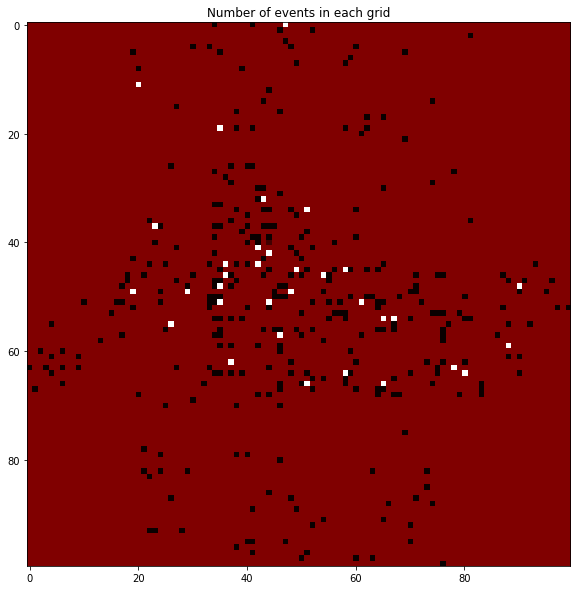

In [67]:
plt.figure(figsize=(20,10))
plt.imshow(h1, cmap = 'hot', interpolation = 'nearest', vmin = 0, vmax = 225)
plt.title("Number of events in each grid")
plt.show()

In [68]:
grid_loc = np.empty((0,0))
for i in range (len(h)):
    for j in range (len(h)):
        if (h[i,j] > 82):
            loc = [i,j]
            grid_loc = np.append(grid_loc, loc)

In [69]:
grid_loc = grid_loc.reshape ((len(grid_loc) // 2, 2))

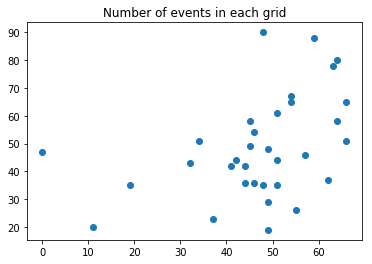

In [70]:
plt.scatter(grid_loc [:,0], grid_loc [:,1])
plt.title("Number of events in each grid")
plt.show()